In [1]:
import tensorflow as tf # Imports tensorflow
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization,Conv2D, MaxPooling2D,concatenate, Conv2DTranspose, Add,  GlobalAveragePooling2D,Input,  Multiply, UpSampling2D, Resizing
from tensorflow.keras.metrics import Accuracy,Recall,Precision,AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.image import resize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
#import imblearn
#from keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os
import sklearn.metrics as m
from glob import glob
from sklearn.model_selection import train_test_split
import skimage.color
import skimage.filters
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gr_shape=(128,128,1)
img_shape = (128,128,3)
input_dir="C:/Users/nidhi/Downloads/data set sample/LIDC-IDRI-slices"
images=[]
masks=[]
y=[]
Thres = 5000/255

In [3]:
# Iterate over patients in the input directory
for patient in os.listdir(input_dir):
    # Check if the item is a directory
    patient_dir = os.path.join(input_dir, patient)
    if not os.path.isdir(patient_dir):
        continue

    # Break loop if images list exceeds 10000
    if len(images) > 10000:
        break

    # Iterate over nodules in the patient directory
    for nodule in os.listdir(patient_dir):
        nodule_dir = os.path.join(patient_dir, nodule)
        if not os.path.isdir(nodule_dir):
            continue

        mask0 = []
        mask1 = []
        mask2 = []
        mask3 = []

        # Load images
        for filename in glob(os.path.join(nodule_dir, 'images', '*.png')):
            img = image.load_img(filename, target_size=img_shape)
            img = np.asarray(img)
            images.append(img)

        # Load masks
        for i, mask_dir in enumerate([mask0, mask1, mask2, mask3]):
            for filename in glob(os.path.join(nodule_dir, f'mask-{i}', '*.png')):
                img = image.load_img(filename, target_size=img_shape)
                img = np.asarray(img)
                mask_dir.append(img)

        # Process masks and labels
        for i in range(len(mask0)):
            white_sum = np.array([mask.sum() for mask in [mask0[i], mask1[i], mask2[i], mask3[i]]])
            cnt = np.sum(white_sum > Thres)
            if cnt > 2:
                y.append(1)
                max_index = white_sum.argmax()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][max_index])
            else:
                y.append(0)
                min_index = white_sum.argmin()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][min_index])

In [4]:
images=np.array(images)/255
masks=np.array(masks)/255
label=np.array(y)

print(images.shape)
print(masks.shape)
print(label.shape)

(10011, 128, 128, 3)
(10011, 128, 128, 3)
(10011,)


In [5]:
yy=pd.DataFrame(label)
yy.value_counts()

1    5097
0    4914
Name: count, dtype: int64

In [6]:
x_train,x_test,y_train,y_test,mask_train,mask_test = train_test_split(images,label,masks,train_size=0.8, random_state=7)
print(x_train.shape)
print(mask_train.shape)

(8008, 128, 128, 3)
(8008, 128, 128, 3)


In [7]:
images = np.nan_to_num(images)
masks = np.nan_to_num(masks )
np.isnan(masks).sum()
masks.shape

(10011, 128, 128, 3)

In [8]:
x_train_added = np.vstack([x_train,x_test[:2000]])
y_train_added = np.concatenate((y_train,y_test[:2000]))
print(x_test.shape)
print(mask_test.shape)


(2003, 128, 128, 3)
(2003, 128, 128, 3)


In [9]:
def mean_iou(y_true, y_pred):
    # Define a function to calculate IoU
    def iou(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
        return iou
    
    # Compute IoU for each class
    ious = iou(y_true, y_pred)
    # Take the mean over classes (excluding the background)
    return K.mean(ious)

# Define the Matthews correlation coefficient (MCC) custom metric function
def mcc(y_true, y_pred):
    y_pred_pos = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = tf.keras.backend.sum(y_pos * y_pred_pos)
    tn = tf.keras.backend.sum(y_neg * y_pred_neg)

    fp = tf.keras.backend.sum(y_neg * y_pred_pos)
    fn = tf.keras.backend.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = tf.keras.backend.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + tf.keras.backend.epsilon())

    return numerator / (denominator + tf.keras.backend.epsilon())

In [11]:
Name='ALEXNET'
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, Resizing
from tensorflow.keras.models import Model

def alexnet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv1)

    conv2 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)

    conv3 = Conv2D(384, (3, 3), activation='relu', padding='same')(pool2)

    conv4 = Conv2D(384, (3, 3), activation='relu', padding='same')(conv3)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv5)

    # Upsampling to match target label dimensions
    upsample1 = UpSampling2D(size=(3, 3))(pool5)

    # Resize to match the target label dimensions
    resized_output = Resizing(128, 128)(upsample1)

    # Output layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(resized_output)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='alexnet')
    return model

# Assuming input shape (height, width, channels) as (128, 128, 3)
input_shape = (128, 128, 3)
alexnet = alexnet_model(input_shape)
alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Accuracy(), Recall(), Precision(), AUC(),mean_iou, mcc])
alexnet.summary()

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 384)         8851

In [12]:

    results = alexnet.fit(x_train,mask_train, validation_data=(x_test,mask_test), batch_size=32, epochs=150,)


Epoch 1/150
251/251 [==============================] - 753s 3s/step - loss: 0.0310 - accuracy: 0.0000e+00 - recall: 0.0041 - precision: 0.0086 - auc: 0.8811 - mean_iou: 0.0199 - mcc: 1.3615e-05 - val_loss: 0.0179 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.9734 - val_mean_iou: 0.0334 - val_mcc: 0.0000e+00
Epoch 2/150
251/251 [==============================] - 750s 3s/step - loss: 0.0168 - accuracy: 0.0000e+00 - recall: 0.0063 - precision: 0.6934 - auc: 0.9748 - mean_iou: 0.0348 - mcc: 0.0120 - val_loss: 0.0161 - val_accuracy: 0.0000e+00 - val_recall: 0.0497 - val_precision: 0.7865 - val_auc: 0.9798 - val_mean_iou: 0.0313 - val_mcc: 0.0892
Epoch 3/150
251/251 [==============================] - 747s 3s/step - loss: 0.0155 - accuracy: 0.0000e+00 - recall: 0.1478 - precision: 0.6464 - auc: 0.9779 - mean_iou: 0.0401 - mcc: 0.2104 - val_loss: 0.0151 - val_accuracy: 0.0000e+00 - val_recall: 0.2091 - val_precision: 0.6351 - val_auc: 0.9821 - val

NameError: name 'unet' is not defined

In [17]:
alexnet.save(Name+'.h5')
model = alexnet

C:\Users\nidhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
 pd.DataFrame.from_dict(results.history).to_csv(Name+'new.csv',index=False)

In [49]:
new_impr= alexnet.predict(x_train)

251/251 [==============================] - 159s 632ms/step


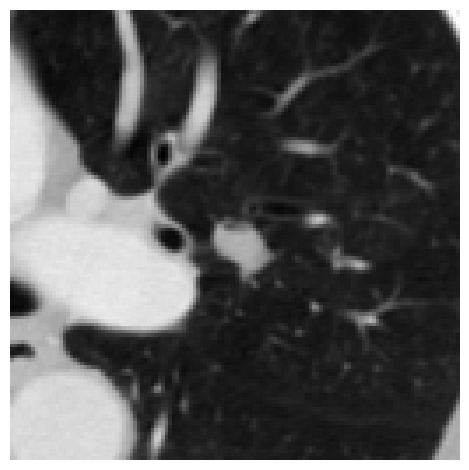

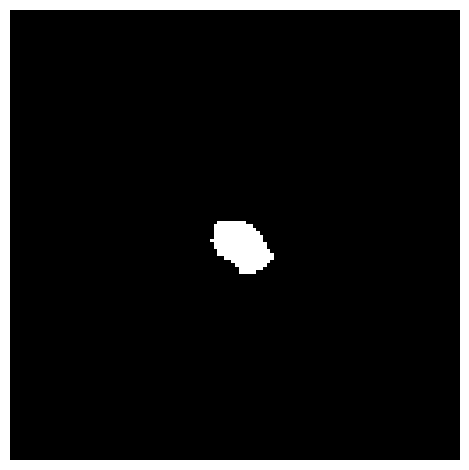

1/1 [==============================] - 0s 161ms/step


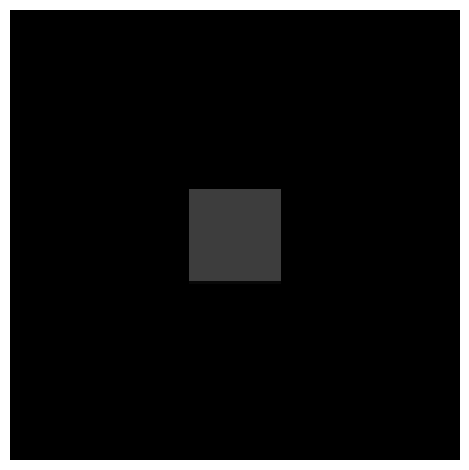

In [50]:

img_id=1789
new_img= np.array(x_train[img_id])
plt.imshow(x_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(mask_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
new_img = new_img.reshape(1,128,128,3)
new_impr= model.predict(new_img)
plt.imshow(new_impr[0])
plt.axis('off')
plt.tight_layout()
#plt.savefig("Activation_Layer5D7"+'.png')
plt.show()


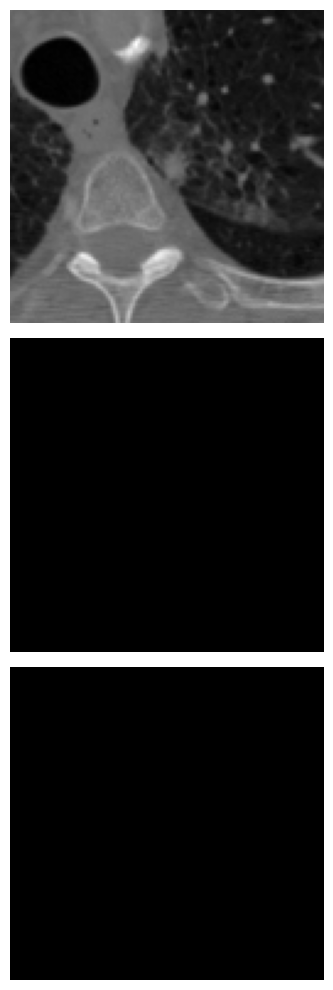

In [23]:
img_id=1019
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(3, 1, 1)
plt.imshow(x_train[img_id])
#a.set_title("original",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 2)
plt.imshow(mask_train[img_id])
#a.set_title("True Mask",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 3)
plt.imshow(new_impr[img_id],interpolation='nearest')
#a.set_title("Predicted",fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.savefig("Segmentation"+str(img_id)+'.png')
plt.show()

In [52]:
# Assuming model is your trained model and x_test contains the test images
prediction = model.predict(x_test)
# Reshape y_score to match the shape of y_test
predictions_binary = prediction.max(axis=(1, 2, 3))
threshold = 0.65
predictions_binary = (predictions_binary > threshold).astype(np.uint8)

63/63 [==============================] - 40s 626ms/step


In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the threshold for binarization
threshold = 0.65

# Function to convert the mask to binary format
def binarize_mask(mask):
    return np.where(mask > threshold, 255, 0).astype(np.uint8)

# Function to find contours and compute area of white regions
def compute_white_area(mask):
    # Convert the mask to binary format
    binary_mask = binarize_mask(mask)
    # Convert the binary mask to a single-channel image
    binary_mask_single_channel = cv2.cvtColor(binary_mask, cv2.COLOR_RGB2GRAY)
    # Find contours of white regions
    contours, _ = cv2.findContours(binary_mask_single_channel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Compute total area of white regions
    total_area = sum(cv2.contourArea(contour) for contour in contours)
    return total_area

# Calculate white area for mask_train[img_id]
mask_train_white_area = compute_white_area(mask_train[img_id])
print("White area in mask_train:", mask_train_white_area)

# Calculate white area for new_impr[img_id]
new_impr_white_area = compute_white_area(new_impr[img_id])
print("White area in new_impr:", new_impr_white_area)

# Display the images
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(3, 1, 1)
plt.imshow(x_train[img_id])
plt.axis('off')

a = fig.add_subplot(3, 1, 2)
plt.imshow(mask_train[img_id])
plt.axis('off')

a = fig.add_subplot(3, 1, 3)
plt.imshow(new_impr[img_id], interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()


White area in mask_train: 157.5


IndexError: index 1789 is out of bounds for axis 0 with size 1

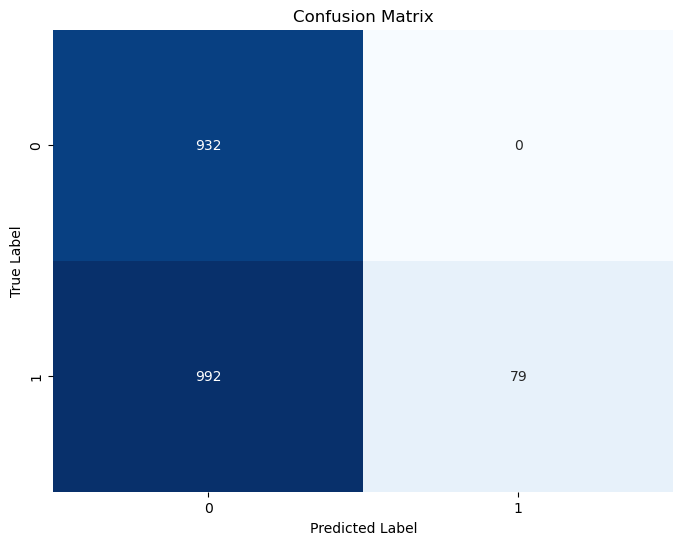

In [44]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


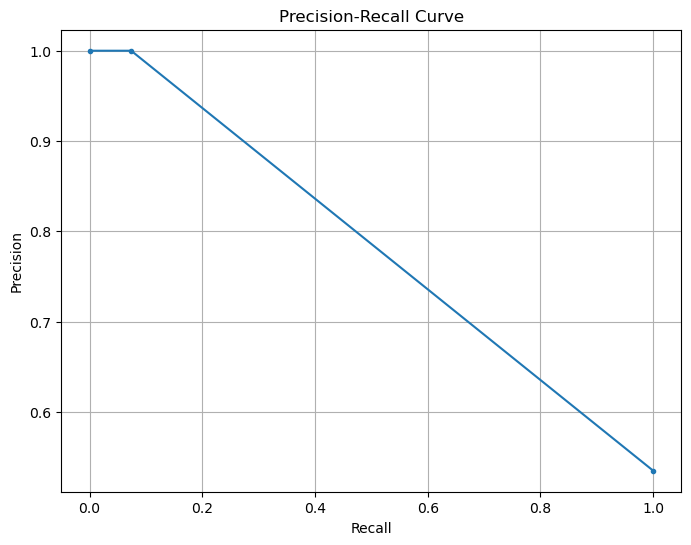

In [45]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, predictions_binary)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

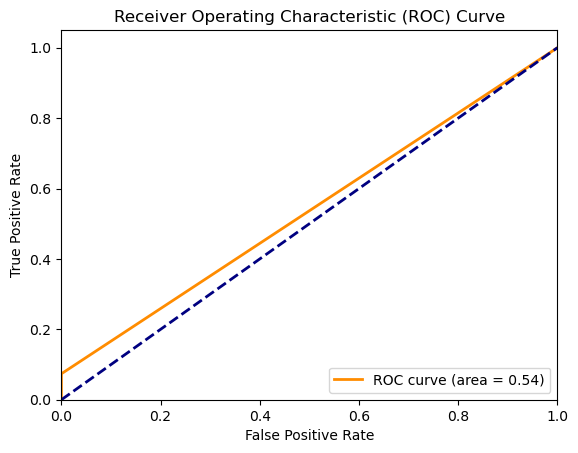

In [46]:

# Assuming y_test contains the true labels
fpr, tpr, thresholds = roc_curve(y_test, predictions_binary)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

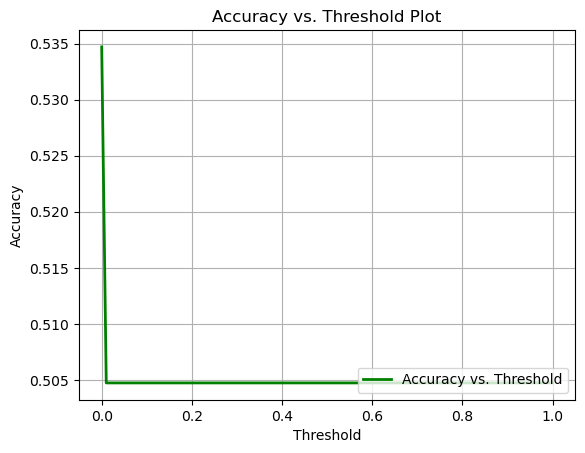

In [47]:

# Assuming y_test contains the true labels
# and y_score contains the predicted scores or probabilities
thresholds = np.linspace(0, 1, 100)
accuracies = []

for threshold in thresholds:
    y_pred = (predictions_binary >= threshold).astype(int)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Plotting the Accuracy vs. Threshold plot
plt.figure()
plt.plot(thresholds, accuracies, color='green', lw=2, label='Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Plot')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


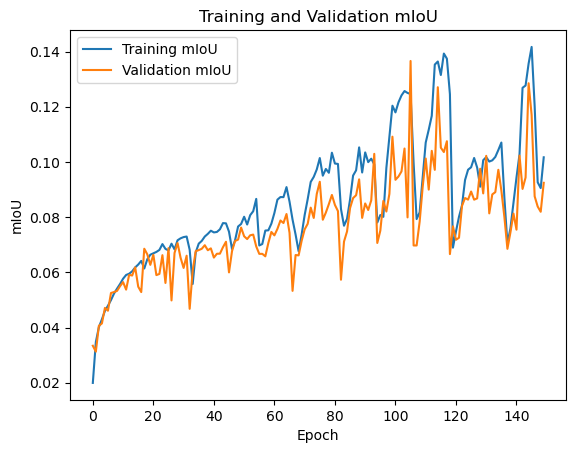

In [48]:
# Retrieve the mIoU values from the history object
train_miou = results.history['mean_iou']
val_miou = results.history['val_mean_iou']

plt.plot(train_miou, label='Training mIoU')
plt.plot(val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()
plt.show()